In [1]:
# Basic Imports:
!pip install xgboost==2.0.0
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Read-in Titanic survivors training data as df
# and display the first 5 rows

data_source = 'train.csv'
df = pd.read_csv(data_source)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Print basic information about the data

print(f'Shape of data: {df.shape} \n')

print(f'Number of null values in each column: \n{df.isna().sum(axis = 0)} \n')

print(f'Number of unique values in each column: \n{df.nunique()} \n')

Shape of data: (891, 12) 

Number of null values in each column: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

Number of unique values in each column: 
PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64 



In [4]:
# Method 1: median
df['Age'].fillna(df.groupby(['Pclass', 'Sex'])['Age'].transform('median'), inplace = True)

# # Method 2: Random forest
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# # Selecting the data subset for age imputation
# AgePre = df[['Age', 'Sex', 'Parch', 'Pclass', 'SibSp', 'Name']]

# # One-hot encoding categorical variables
# SexAge = pd.get_dummies(AgePre['Sex'], prefix='Sex')
# ParAge = pd.get_dummies(AgePre['Parch'], prefix='Parch')
# AgePre['Name_Title'] = AgePre['Name'].str.extract(r',\s*([^\.]+)\.')
# TitleAge = pd.get_dummies(AgePre['Name_Title'], prefix='Title')

# # Concatenating one-hot encoded columns to AgePre
# AgePre = pd.concat([AgePre, ParAge, TitleAge, SexAge], axis=1)

# # Dropping original categorical columns (since they are now one-hot encoded)
# AgePre = AgePre.drop(['Parch', 'Sex', 'Name', 'Name_Title'], axis=1)

# # Splitting data into known and unknown age sets
# AgeKnown = AgePre[AgePre['Age'].notnull()]
# AgeUnknown = AgePre[AgePre['Age'].isnull()]

# # Defining features and labels for known ages
# AgeKnown_X = AgeKnown.drop(['Age'], axis=1)
# AgeKnown_y = AgeKnown['Age']

# # Defining features for unknown ages
# AgeUnknown_X = AgeUnknown.drop(['Age'], axis=1)

# # Training RandomForestRegressor to predict missing Age values
# rfr = RandomForestRegressor(random_state=42, n_estimators=2000, n_jobs=-1)
# rfr.fit(AgeKnown_X, AgeKnown_y)

# # Predicting missing Age values
# predicted_ages = rfr.predict(AgeUnknown_X)

# # Filling in the missing Age values in the original DataFrame
# df.loc[df['Age'].isnull(), 'Age'] = predicted_ages

In [5]:
# Transform 'Sex' column to binary
# could have just used label encoder -- oops

df['Sex'] = df['Sex'].replace({'female': 1, 'male': 0}).infer_objects(copy=False) #.fillna(df['Sex'])
df = pd.get_dummies(df, columns=['Embarked'], drop_first=False, dtype=int)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,1


In [6]:
# I am thinking that the 'Cabin' column could indicate where people were when the titanic sunk at 2am
# This could be helpful in predicting survival, but there are a lot of missing values
# Creates a column for the cabin letter

df['Cabin_Letter'] = df['Cabin'].str[0]
print(f'Unique values in Cabin_Letter: \n{df["Cabin_Letter"].value_counts()}')

# Target Encode 'Cabin_Letter'. 
# NOTE: We could also use One Hot Encoding here. Just trying to reduce number of cols
# OHE: df = pd.get_dummies(df, columns=['Cabin_Letter'], drop_first=False, dtype=int)

df['Cabin_Letter'] = df['Cabin_Letter'].fillna('Unknown')
df = pd.get_dummies(df, columns=['Cabin_Letter'], drop_first=False, dtype=int)
df.head()

Unique values in Cabin_Letter: 
Cabin_Letter
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_S,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Cabin_Letter_Unknown
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,1,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,0,0,0,1,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0,0,0,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,...,1,0,0,1,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,...,1,0,0,0,0,0,0,0,0,1


In [7]:
# Extract titles from name like Mr., Mrs., Dr., etc.
# Feel that this may be useful? to infer marriage or education status - SY

df['Name_Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.')
df['Name_Length'] = df['Name'].str.len()
title_counts = df['Name_Title'].value_counts()
print(title_counts)

Name_Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64


In [8]:
# Define the list of titles we want to keep
title_mapping = {
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Dr": "Officer",
    "Rev": "Officer",
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Lady" : "Royalty", 
    "Don": "Royalty",
    "Sir" : "Royalty",
    "the Countess":"Royalty"
}
df['Name_Title'] = df['Name_Title'].map(title_mapping)

valid_titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Officer', 'Royalty']
# Replace titles not in the valid list with 'Other'
df['Name_Title'] = df['Name_Title'].where(df['Name_Title'].isin(valid_titles), 'Other')

df = pd.get_dummies(df, columns=['Name_Title'], drop_first=False, dtype=int)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_Letter_G,Cabin_Letter_T,Cabin_Letter_Unknown,Name_Length,Name_Title_Master,Name_Title_Miss,Name_Title_Mr,Name_Title_Mrs,Name_Title_Officer,Name_Title_Royalty
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,0,0,1,23,0,0,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,0,0,0,51,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,1,22,0,1,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,...,0,0,0,44,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,...,0,0,1,24,0,0,1,0,0,0


In [9]:
# Get cabin number and drop cabin column
# Extract the number from the 'Cabin' column using regex
df['Cabin_Number'] = df['Cabin'].str.extract(r'(\d+)', expand=False)

# Convert the extracted number to a numeric type
# Don't think it is really useful for model
df['Cabin_Number'] = pd.to_numeric(df['Cabin_Number'], errors='coerce')
df['Cabin_Number'] = df['Cabin_Number'].fillna(0)

# According to https://colab.research.google.com/drive/1QDXe2YBuxYqejVq0qApZTbw5h96BokF8?usp=sharing#scrollTo=22ea17b9-73b0-416b-80a7-b94f598acca1 
cabin_bins = [0, 20, 40, 60, 80, 100, 140]  # Adjust these ranges if needed based on the histogram pattern
cabin_labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '101-140']

# Create a new column 'Cabin_Number_Bin' that categorizes 'Cabin_Number' into bins
df['Cabin_Number_Bin'] = pd.cut(df['Cabin_Number'], bins=cabin_bins, labels=cabin_labels, include_lowest=True)
df = pd.get_dummies(df, columns=['Cabin_Number_Bin'], drop_first=False, dtype=int)

df = df.drop(columns=['Cabin', 'Ticket', 'Name'])
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,...,Name_Title_Mrs,Name_Title_Officer,Name_Title_Royalty,Cabin_Number,Cabin_Number_Bin_0-20,Cabin_Number_Bin_21-40,Cabin_Number_Bin_41-60,Cabin_Number_Bin_61-80,Cabin_Number_Bin_81-100,Cabin_Number_Bin_101-140
0,1,0,3,0,22.0,1,0,7.2500,0,0,...,0,0,0,0.0,1,0,0,0,0,0
1,2,1,1,1,38.0,1,0,71.2833,1,0,...,1,0,0,85.0,0,0,0,0,1,0
2,3,1,3,1,26.0,0,0,7.9250,0,0,...,0,0,0,0.0,1,0,0,0,0,0
3,4,1,1,1,35.0,1,0,53.1000,0,0,...,1,0,0,123.0,0,0,0,0,0,1
4,5,0,3,0,35.0,0,0,8.0500,0,0,...,0,0,0,0.0,1,0,0,0,0,0


In [10]:
df['is_child'] = (df['Age'] <= 10).astype(int)
df['family_size'] = df["SibSp"] + df["Parch"] + 1

# Define a function to classify family size into categories
def classify_family_size(familyNum):
    if familyNum == 1:
        return 'Small'     # Single passenger (considered small family)
    elif 2 <= familyNum <= 4:
        return 'Medium'    # Family size between 2 and 4
    else:
        return 'Large'     # Family size greater than 4

# Apply the function to classify family size
df['Family_Size_Category'] = df['family_size'].map(classify_family_size)
df = pd.get_dummies(df, columns=['Family_Size_Category'], drop_first=False, dtype=int)

In [11]:
# Create a new column 'Mother' initialized to 0
df['Mother'] = 0

# Update 'Mother' to 1 if 'Name' contains 'Mrs' and 'Parch' > 1
df['Mother'] = np.where((df['Name_Title_Mrs'] == 1) & (df['Parch'] > 1), 1, 0)

# Baseline Model to Beat: 0.7821229050279329

In [12]:
X_baseline = df[['Sex']]
y_baseline = df['Survived']

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, test_size = 0.2, random_state = 42)

baseline_model = LogisticRegression()
baseline_model.fit(X_train_baseline, y_train_baseline)
y_pred = baseline_model.predict(X_test_baseline)
print(accuracy_score(y_test_baseline, y_pred))

0.7821229050279329


In [13]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,...,Cabin_Number_Bin_41-60,Cabin_Number_Bin_61-80,Cabin_Number_Bin_81-100,Cabin_Number_Bin_101-140,is_child,family_size,Family_Size_Category_Large,Family_Size_Category_Medium,Family_Size_Category_Small,Mother
0,1,0,3,0,22.0,1,0,7.2500,0,0,...,0,0,0,0,0,2,0,1,0,0
1,2,1,1,1,38.0,1,0,71.2833,1,0,...,0,0,1,0,0,2,0,1,0,0
2,3,1,3,1,26.0,0,0,7.9250,0,0,...,0,0,0,0,0,1,0,0,1,0
3,4,1,1,1,35.0,1,0,53.1000,0,0,...,0,0,0,1,0,2,0,1,0,0
4,5,0,3,0,35.0,0,0,8.0500,0,0,...,0,0,0,0,0,1,0,0,1,0


In [14]:
df['Fare_Pclass'] = df['Fare'] * df['Pclass']
df['Sex_Pclass'] = df['Sex'] * df['Pclass']
df['Sex_Fare'] = df['Sex'] * df['Fare']


# dont think these are super super relevant to prediciting surviviablity but can revist
#df.drop(columns = ['Name', 'Ticket', 'PassengerId', 'Embarked'], inplace = True)


df['Age_bin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 80], labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])
df['Fare_bin'] = pd.qcut(df['Fare'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df = pd.get_dummies(df, columns=['Fare_bin'], drop_first=False, dtype=int)
df = pd.get_dummies(df, columns=['Age_bin'], drop_first=False, dtype=int)

In [15]:
# From Blake's notebook: Conventionally think that women, children and high class would be saved first
df['Stereotype'] = (1/df['Age']) + df['Sex'] + (1/df['Pclass'])

In [16]:
# Scaling but not used
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_p = scaler.fit(df['Age'].values.reshape(-1,1))
df['Age_scaled'] = scaler.fit_transform(df['Age'].values.reshape(-1,1), age_scale_p)

fare_scale_param = scaler.fit(df['Fare'].values.reshape(-1,1))
df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1,1), fare_scale_param)

name_scale_p = scaler.fit(df['Name_Length'].values.reshape(-1,1))
df['Name_Length_scaled'] = scaler.fit_transform(df['Name_Length'].values.reshape(-1,1), name_scale_p)

fare_pclass_scale_param = scaler.fit(df['Fare_Pclass'].values.reshape(-1,1))
df['Fare_Pclass_scaled'] = scaler.fit_transform(df['Fare_Pclass'].values.reshape(-1,1), fare_pclass_scale_param)

In [17]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T',
       'Cabin_Letter_Unknown', 'Name_Length', 'Name_Title_Master',
       'Name_Title_Miss', 'Name_Title_Mr', 'Name_Title_Mrs',
       'Name_Title_Officer', 'Name_Title_Royalty', 'Cabin_Number',
       'Cabin_Number_Bin_0-20', 'Cabin_Number_Bin_21-40',
       'Cabin_Number_Bin_41-60', 'Cabin_Number_Bin_61-80',
       'Cabin_Number_Bin_81-100', 'Cabin_Number_Bin_101-140', 'is_child',
       'family_size', 'Family_Size_Category_Large',
       'Family_Size_Category_Medium', 'Family_Size_Category_Small', 'Mother',
       'Fare_Pclass', 'Sex_Pclass', 'Sex_Fare', 'Fare_bin_Very Low',
       'Fare_bin_Low', 'Fare_bin_Medium', 'Fare_bin_High',
       'Fare_bin_Very High', 'Age_bin_Child', 'Age_bin_Teen',
   

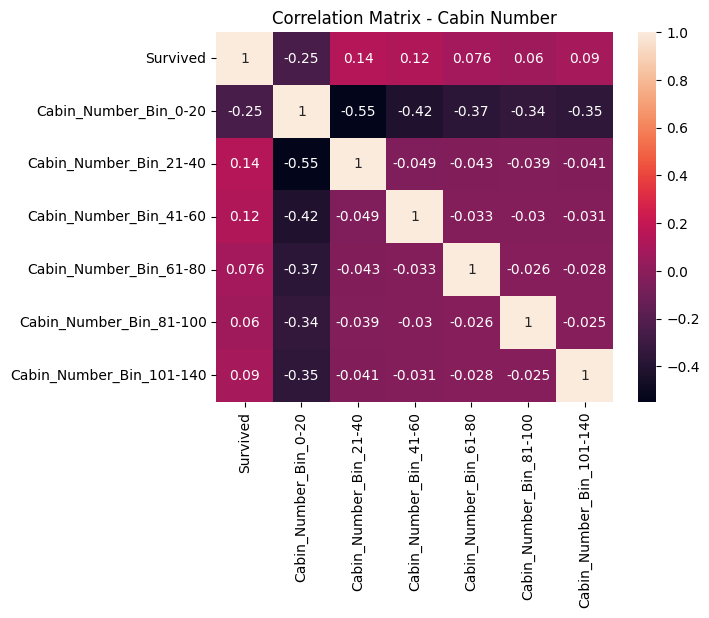

In [18]:
df_corr1 = df[["Survived", 'Cabin_Number_Bin_0-20',
       'Cabin_Number_Bin_21-40', 'Cabin_Number_Bin_41-60',
       'Cabin_Number_Bin_61-80', 'Cabin_Number_Bin_81-100',
       'Cabin_Number_Bin_101-140']]
correlation = df_corr1.corr()
sns.heatmap(correlation, annot = True)
plt.title('Correlation Matrix - Cabin Number')
plt.show()

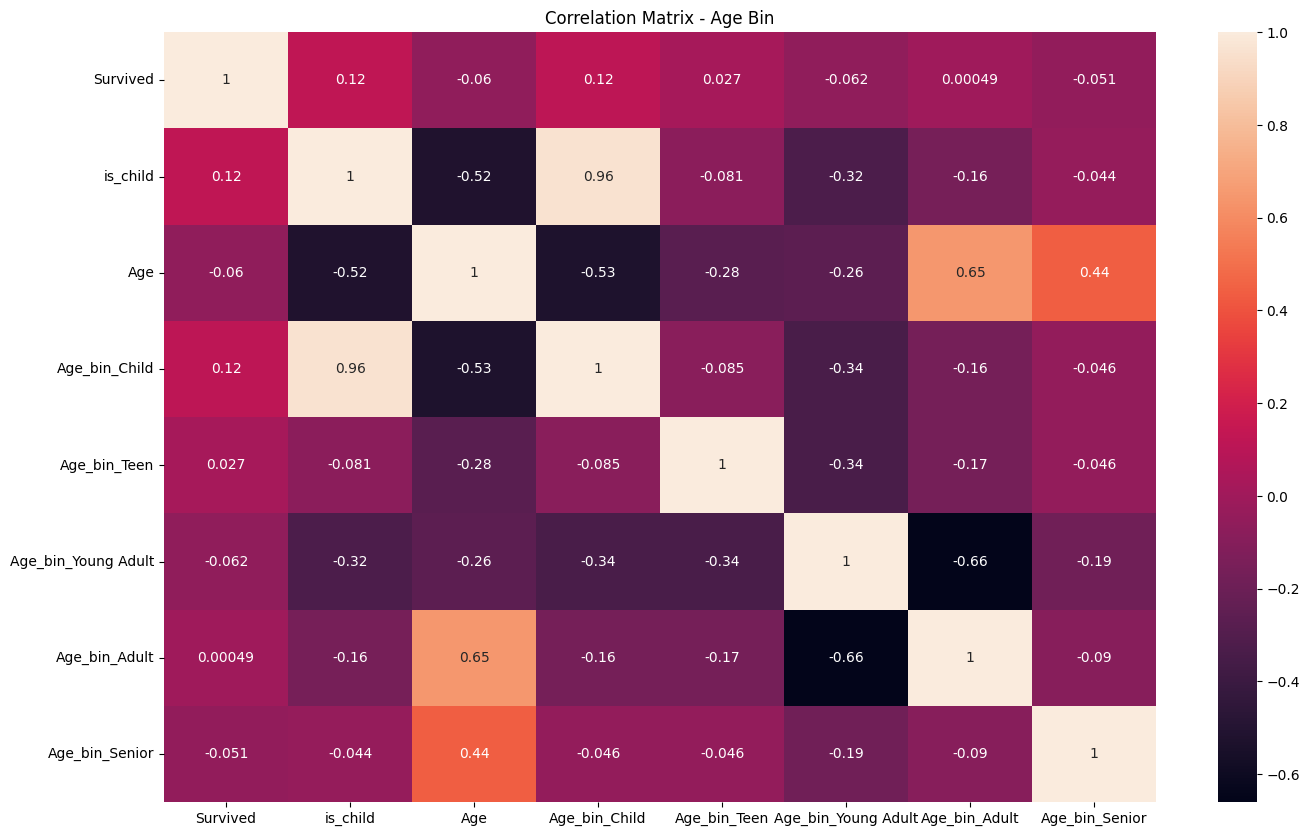

In [19]:
plt.figure(figsize=(16, 10))
df_corr2 = df[['Survived', 'is_child', 'Age', 'Age_bin_Child', 'Age_bin_Teen', 'Age_bin_Young Adult', 'Age_bin_Adult',
       'Age_bin_Senior']]
# Embarked_Q and Cabin Letter A, and Name title Master seems to have low assosiation so we did not display them
correlation = df_corr2.corr()
sns.heatmap(correlation, annot = True)
plt.title('Correlation Matrix - Age Bin')
plt.show()

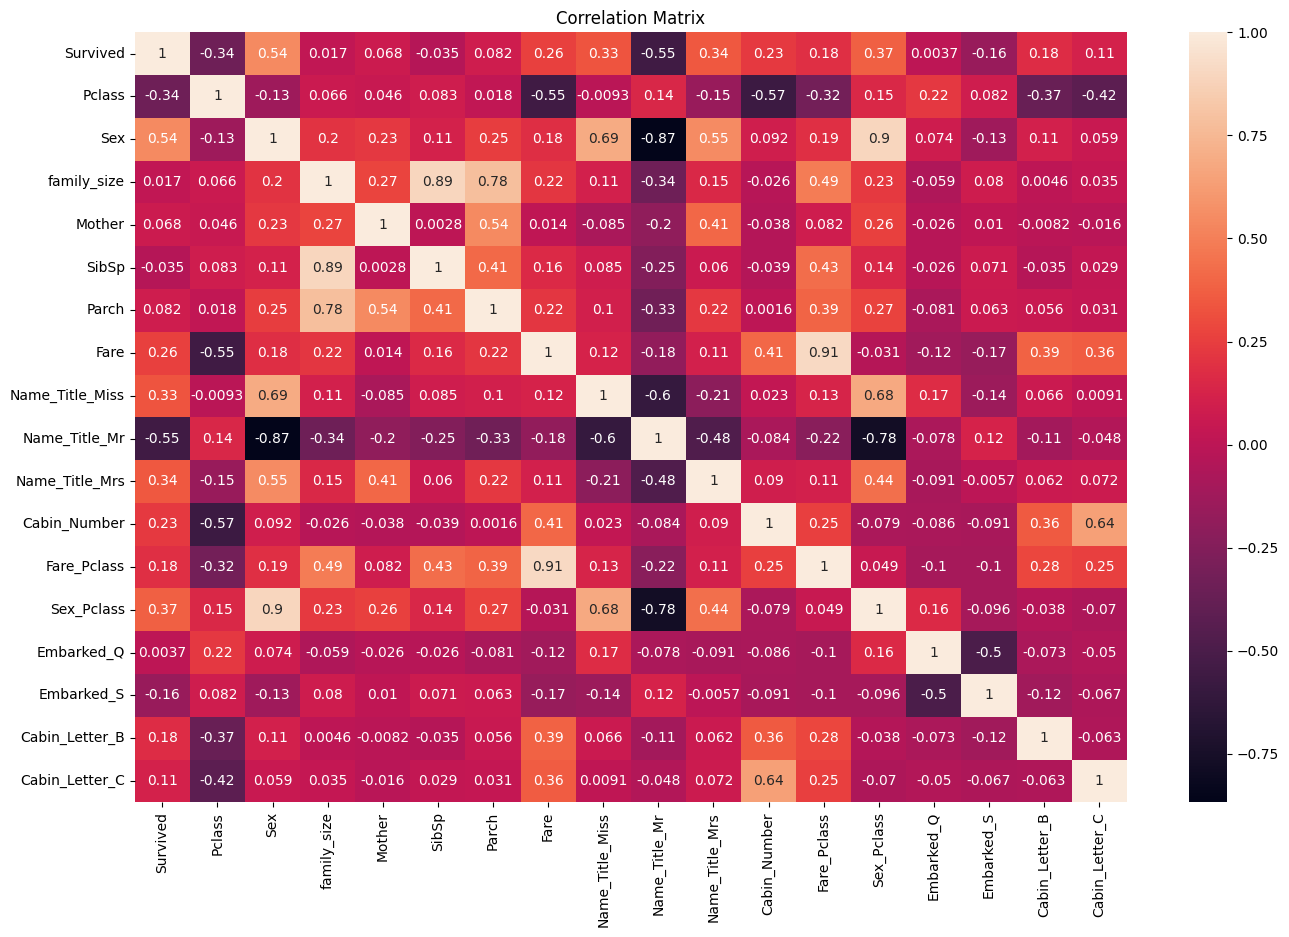

In [20]:
plt.figure(figsize=(16, 10))
df_corr3 = df[['Survived', 'Pclass', 'Sex', 
       'family_size', 'Mother', 'SibSp', 'Parch',
       'Fare', 'Name_Title_Miss',
       'Name_Title_Mr', 'Name_Title_Mrs', 'Cabin_Number', 'Fare_Pclass', 'Sex_Pclass', 'Embarked_Q', 'Embarked_S',
       'Cabin_Letter_B', 'Cabin_Letter_C']]
# Embarked_Q and Cabin Letter A, and Name title Master seems to have low assosiation so we did not display them
correlation = df_corr3.corr()
sns.heatmap(correlation, annot = True)
plt.title('Correlation Matrix')
plt.show()

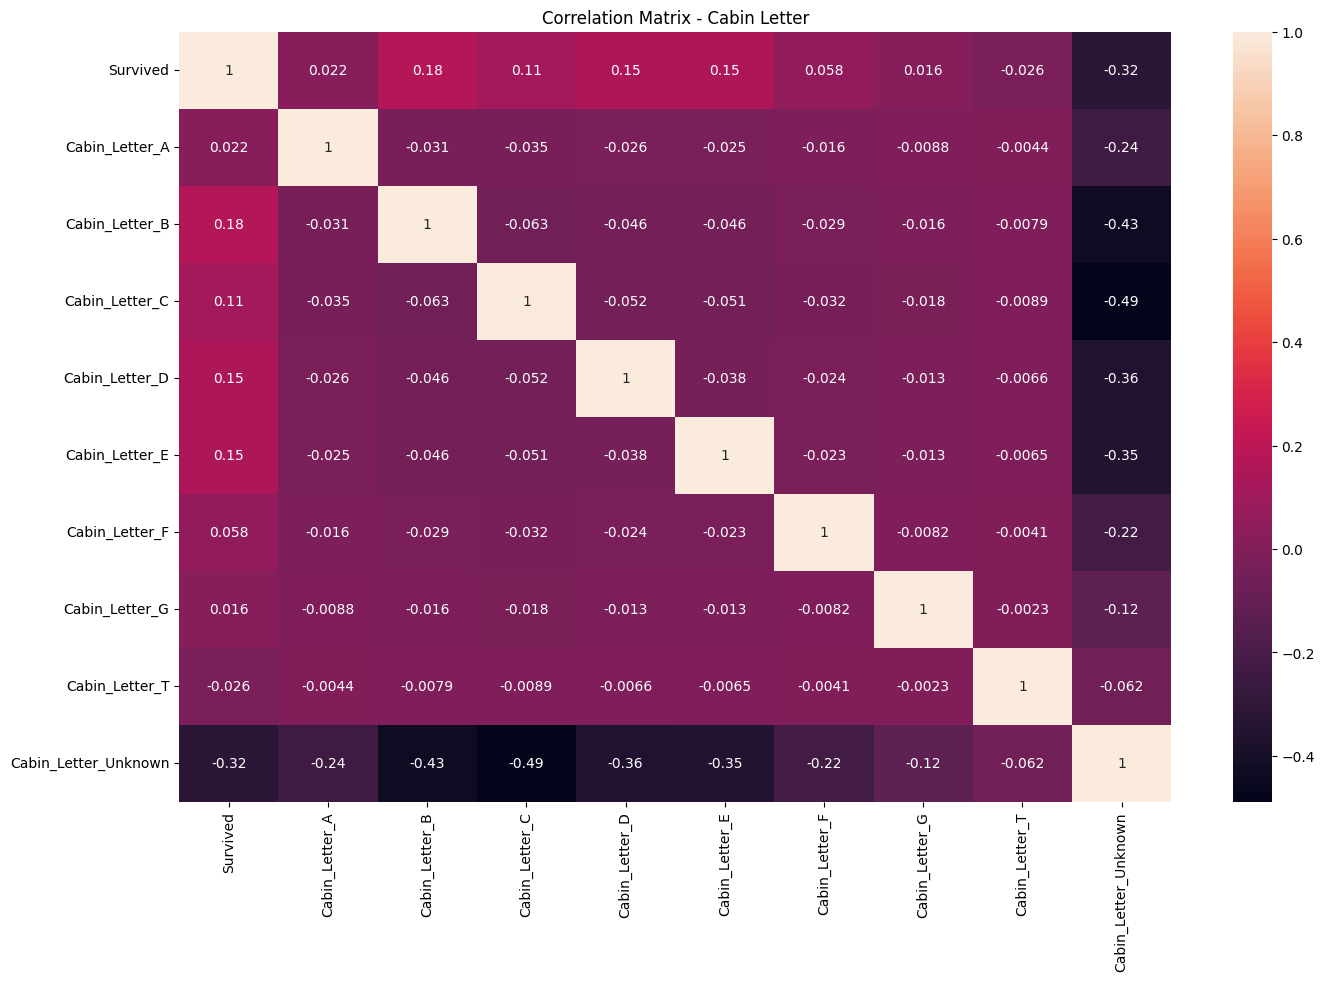

In [21]:
plt.figure(figsize=(16, 10))
df_corr4 = df[['Survived', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T',
       'Cabin_Letter_Unknown']]
# Embarked_Q and Cabin Letter A, and Name title Master seems to have low assosiation so we did not display them
correlation = df_corr4.corr()
sns.heatmap(correlation, annot = True)
plt.title('Correlation Matrix - Cabin Letter')
plt.show()

/tmp/ipykernel_1223/3003810148.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df["Survived"] == 1, feature], label="1", fill=True, ax=ax)
/tmp/ipykernel_1223/3003810148.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df["Survived"] == 0, feature], label="0", fill=True, ax=ax)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1223/3003810148.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df["Survived"] == 1, feature], label="1", fill=True, ax=ax)


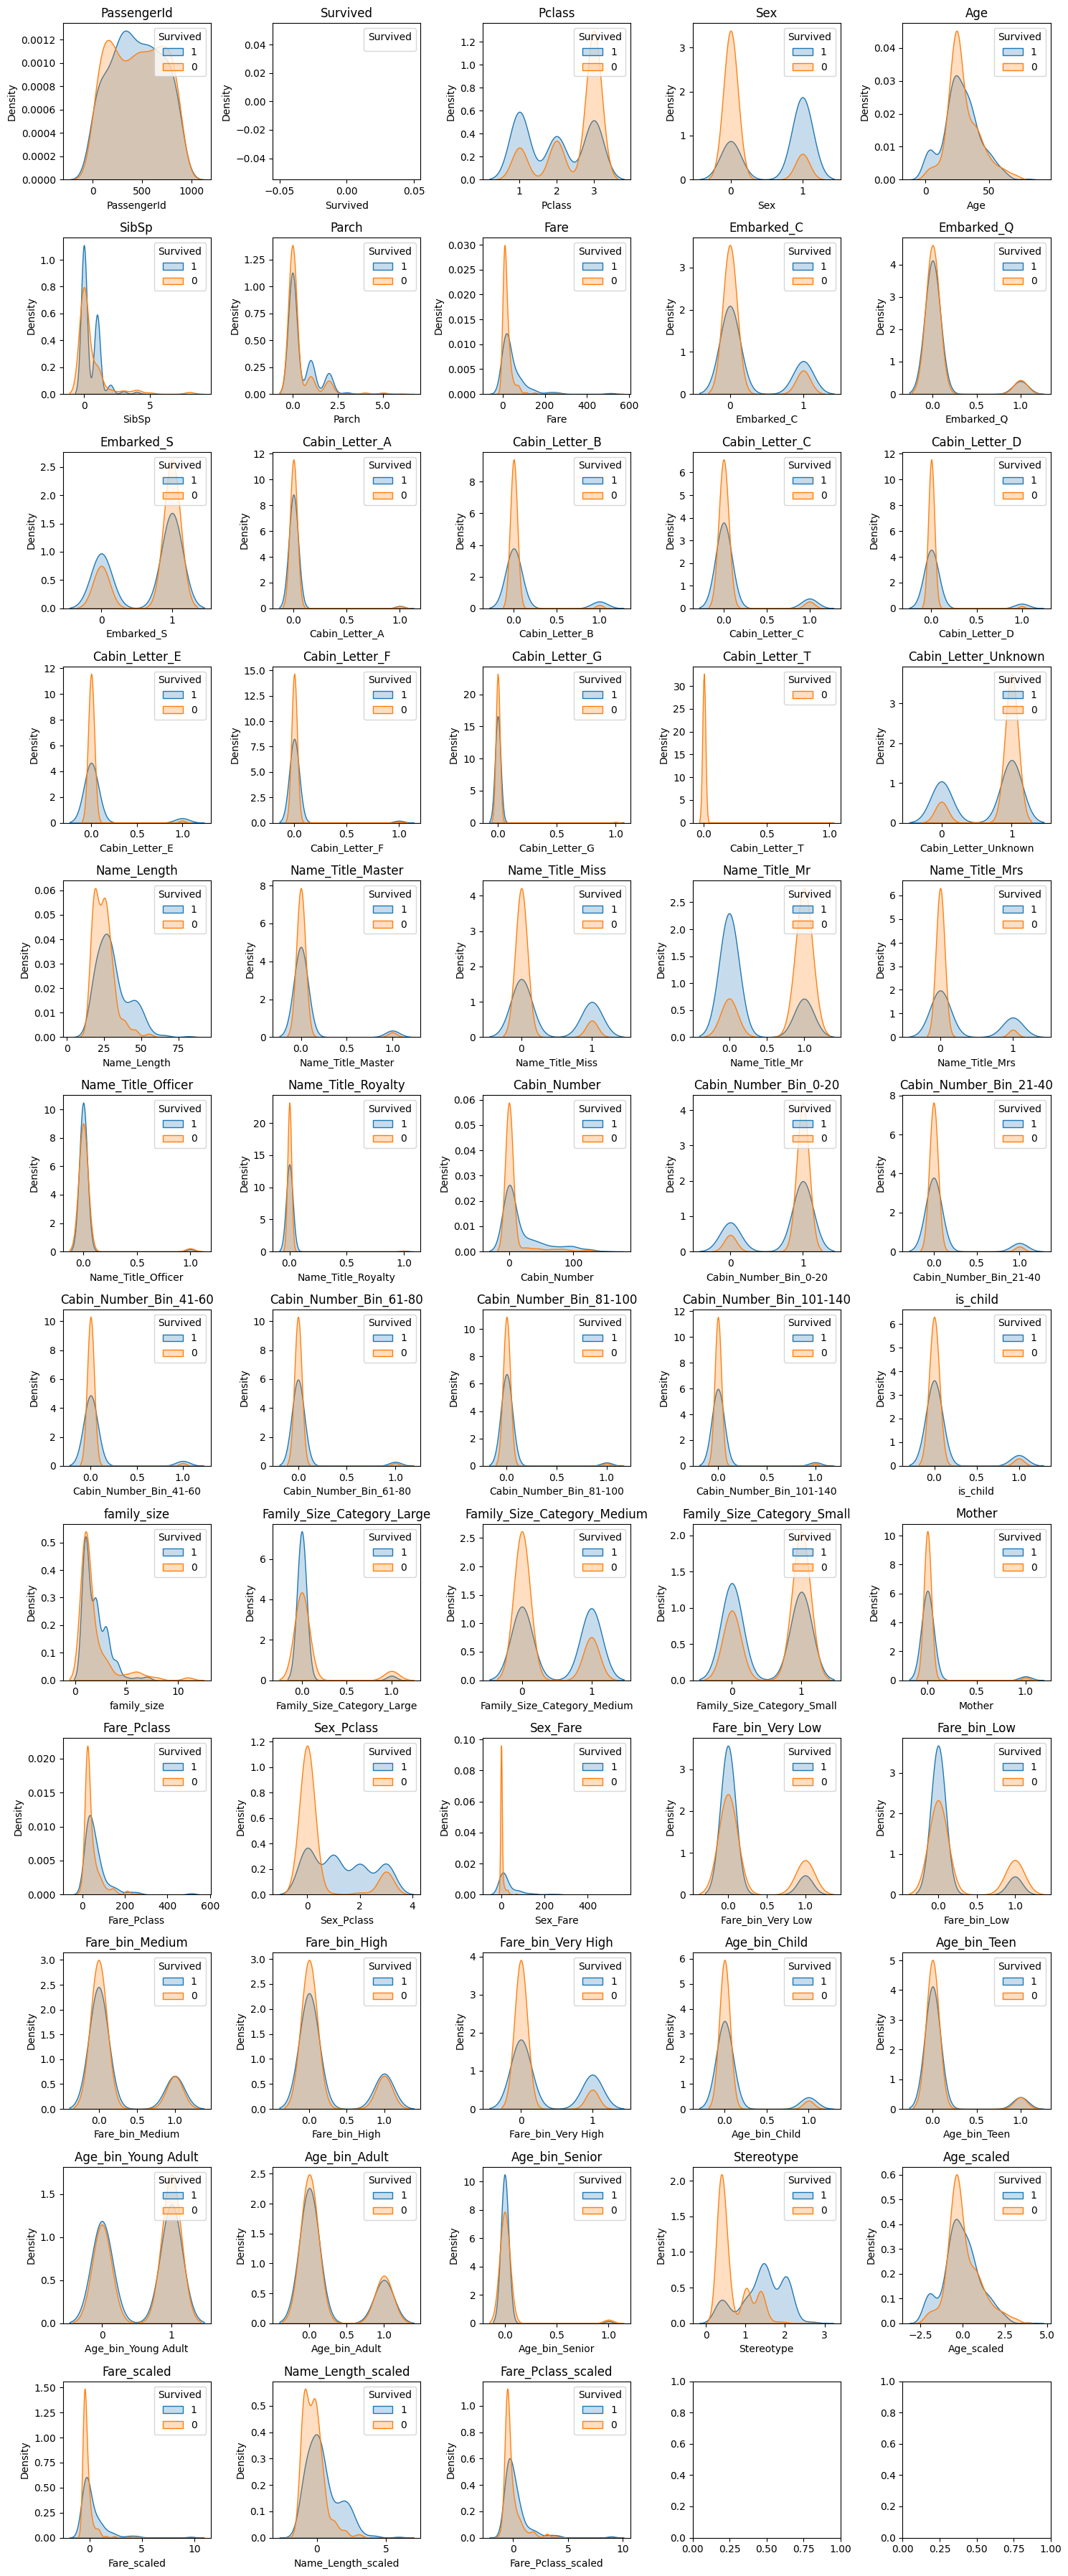

In [22]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# features = ['Sex','Age', 'Cabin_Letter', 'Fare', 'Pclass', 'SibSp', 'Parch']
graphs_per_row = 5
num_rows = (len(numeric_features) // graphs_per_row) + (len(numeric_features) % graphs_per_row > 0)

fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 3 * num_rows), tight_layout=True)
# Flatten axes to iterate easily
axes_flat = axes.flatten()

# Plot each feature
for idx, feature in enumerate(numeric_features):
    ax = axes_flat[idx]
    sns.kdeplot(df.loc[df["Survived"] == 1, feature], label="1", fill=True, ax=ax)
    sns.kdeplot(df.loc[df["Survived"] == 0, feature], label="0", fill=True, ax=ax)
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend(title="Survived")

plt.show()

# Our Model: 

TODO:
1. data preprocessing
    a. feature engineering(above)
    b. with missing values
    c. noise
    d. data transform
    e. split data 
2. model
3. submission

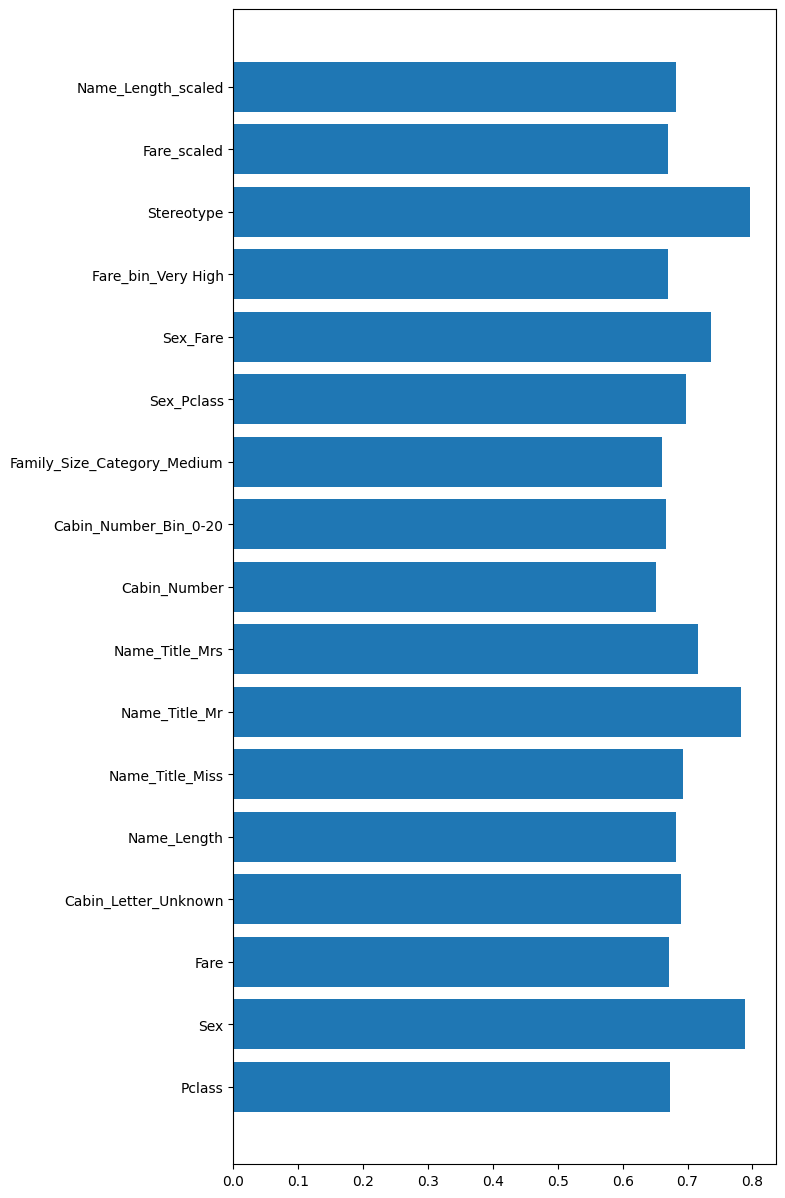

In [53]:
log_corr = {}
# ['Cabin_Letter_T', 'Name_Title_Royalty'] not in test data so have to drop
for x in df.drop(["Survived", 'Cabin_Letter_T', 'Name_Title_Royalty'], axis=1).columns:
    y = df['Survived']
    X_train, X_test, y_train, y_test = train_test_split(df[[x]], y, test_size = 0.2, random_state = 42)

    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    cv_scores = cross_val_score(lr_model, X_train, y_train, cv = 5, scoring = 'accuracy')
    log_corr[x] = np.mean(cv_scores)

plt.figure(figsize=(7, 15))
x_cor = list(log_corr.keys())
x_cor_selected = []
for x in x_cor:
    if log_corr[x] >= 0.65:
        x_cor_selected.append(x)
y_cor = [log_corr[i] for i in x_cor_selected]
plt.barh(x_cor_selected, y_cor)
plt.show()

In [51]:
try_X = df[x_cor_selected]
y = df['Survived']
try_X_train, try_X_test, y_train, y_test = train_test_split(try_X, y, test_size = 0.2, random_state = 42)

,Pclass,Sex,Fare,Cabin_Letter_Unknown,Name_Length,Name_Title_Miss,Name_Title_Mr,Name_Title_Mrs,Cabin_Number,Cabin_Number_Bin_0-20,Family_Size_Category_Medium,Sex_Pclass,Sex_Fare,Fare_bin_Very High,Stereotype,Fare_scaled,Name_Length_scaled
0,3,0,7.2500,1,23,0,1,0,0.0,1,1,0,0.0000,0,0.378788,-0.502445,-0.427451
1,1,1,71.2833,0,51,0,0,1,85.0,0,1,1,71.2833,1,2.026316,0.786845,2.590962
2,3,1,7.9250,1,22,1,0,0,0.0,1,0,3,7.9250,0,1.371795,-0.488854,-0.535252
3,1,1,53.1000,0,44,0,0,1,123.0,0,1,1,53.1000,1,2.028571,0.420730,1.836359
4,3,0,8.0500,1,24,0,1,0,0.0,1,0,0,0.0000,0,0.361905,-0.486337,-0.319651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,13.0000,1,21,0,0,0,0.0,1,0,0,0.0000,0,0.537037,-0.386671,-0.643052
887,1,1,30.0000,0,28,1,0,0,42.0,0,0,1,30.0000,0,2.052632,-0.044381,0.111551
888,3,1,23.4500,1,40,1,0,0,0.0,1,1,3,23.4500,0,1.379845,-0.176263,1.405157
889,1,0,30.0000,0,21,0,1,0,148.0,0,0,0,0.0000,0,1.038462,-0.044381,-0.643052


In [77]:
# X = df[['Sex','Age', 'Fare', 'Cabin_number', 'Pclass', 'SibSp', 'Parch', 'Embarked_C', 'Embarked_S', 'Binned_Cabin_Number']]
X = df[['Cabin_Number_Bin_0-20',
'Cabin_Number_Bin_21-40', 'Cabin_Number_Bin_41-60',
'Cabin_Number_Bin_61-80', 'Cabin_Number_Bin_81-100',
'Cabin_Number_Bin_101-140', 
'Age_bin_Child', 'Age_bin_Teen', 'Age_bin_Young Adult', 'Age_bin_Adult',
'Age_bin_Senior', 
'Pclass', 'Sex', 
'Fare', 'Name_Title_Miss',
'Name_Title_Mr', 'Name_Title_Mrs', 'Name_Title_Master', "SibSp", "Parch", 
'Cabin_Number', 'Fare_Pclass', 'Sex_Pclass', 'Sex_Fare', 
'Embarked_C', 'Embarked_S', "Name_Length",
'Family_Size_Category_Medium', 'Cabin_Letter_Unknown', 'Fare_bin_Very High']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [78]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print(accuracy_score(y_test, y_pred))
cv_scores = cross_val_score(lr_model, X_train, y_train, cv = 5, scoring = 'accuracy')
print(cv_scores)
print(np.mean(cv_scores))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
0.8379888268156425
[0.84615385 0.85314685 0.8028169  0.78873239 0.83098592]
0.824367182113661

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       105
           1       0.81      0.80      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



In [27]:
''' # No use
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 6, 7, 8, 10],
    'min_samples_split': [2, 5, 8, 9, 10, 11, 12, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_dt_model = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_dt_model.predict(X_test)
print(f'Best Decision Tree Accuracy: {accuracy_score(y_test, y_pred)}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# retrain on full set
best_dt_model.fit(X, y)
'''

" # No use\n# Define parameter grid\nparam_grid = {\n    'max_depth': [3, 5, 6, 7, 8, 10],\n    'min_samples_split': [2, 5, 8, 9, 10, 11, 12, 15],\n    'min_samples_leaf': [1, 2, 3, 4, 5]\n}\n\n# Grid search with cross-validation\ngrid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)\ngrid_search.fit(X_train, y_train)\n\n# Best model from grid search\nbest_dt_model = grid_search.best_estimator_\n\n# Predictions and evaluation\ny_pred = best_dt_model.predict(X_test)\nprint(f'Best Decision Tree Accuracy: {accuracy_score(y_test, y_pred)}')\n\nprint('\nClassification Report:')\nprint(classification_report(y_test, y_pred))\n\n# retrain on full set\nbest_dt_model.fit(X, y)\n"

In [56]:
# Warning: will take  minutes
param_grid = {
    'n_estimators': [50,100],  # Number of trees in the forest
    # "criterion":["gini","entropy", "log_loss"],
    # "bootstrap":[True,False],
    'max_depth': [3, 5, 10],              # Depth of the tree
    'min_samples_split': [2, 5, 10],               # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5],                 # Minimum samples required to be at a leaf node
    # 'max_features': ['sqrt', 'log2']      # Number of features to consider for splitting at each node
}

# Grid search with cross-validation using RandomForestClassifier
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_rf_model = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_rf_model.predict(X_test)
print(f'Best Random Forest Accuracy: {accuracy_score(y_test, y_pred)}')
# Print additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Retrain on full set
best_rf_model.fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.811 total time=   0.1s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.825 total time=   0.1s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.746 total time=   0.1s
[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.782 total time=   0.1s
[CV 5/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.796 total time=   0.1s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.825 total time=   0.3s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.839 total time=   0.3s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.746 total time=   0.3s
[CV 4/5

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

In [79]:
# X = df[['Sex','Age', 'Fare', 'Cabin_number', 'Pclass', 'SibSp', 'Parch', 'Embarked_C', 'Embarked_S', 'Binned_Cabin_Number']]
# Manually tune the detailed parameters after running grid search
rfmodel = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

rfmodel.fit(X_train, y_train)
y_pred = rfmodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
# Print additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# retrain on full set
rfmodel.fit(X, y)

0.8156424581005587

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

In [60]:
# Try using lr corr selected features
# Warning: will take  minutes
param_grid = {
    'n_estimators': [50,100],  # Number of trees in the forest
    # "criterion":["gini","entropy", "log_loss"],
    # "bootstrap":[True,False],
    'max_depth': [3, 5, 10],              # Depth of the tree
    'min_samples_split': [2, 5, 10],               # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5],                 # Minimum samples required to be at a leaf node
    # 'max_features': ['sqrt', 'log2']      # Number of features to consider for splitting at each node
}

# Grid search with cross-validation using RandomForestClassifier
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(try_X_train, y_train)

# Best model from grid search
try_best_rf_model = grid_search.best_estimator_

# Predictions and evaluation
try_y_pred = try_best_rf_model.predict(try_X_test)
print(f'Best Random Forest Accuracy: {accuracy_score(y_test, try_y_pred)}')
# Print additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, try_y_pred))

# Retrain on full set
try_best_rf_model.fit(try_X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.811 total time=   0.1s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.832 total time=   0.1s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.775 total time=   0.1s
[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.775 total time=   0.1s
[CV 5/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.796 total time=   0.1s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.790 total time=   0.2s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.825 total time=   0.2s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.789 total time=   0.2s
[CV 4/5

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

In [61]:
# Try using lr corr selected features
# Manually tune the detailed parameters after running grid search
try_rfmodel = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

try_rfmodel.fit(try_X_train, y_train)
try_y_pred = try_rfmodel.predict(try_X_test)

accuracy = accuracy_score(y_test, try_y_pred)
print(accuracy)
# Print additional evaluation metrics
print('\ntry_rfmodel Classification Report:')
print(classification_report(y_test, try_y_pred))
# retrain on full set
try_rfmodel.fit(try_X, y)

0.8212290502793296

try_rfmodel Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       105
           1       0.84      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

In [64]:
# Try using lr corr selected features
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Try ensemble
# Define the RandomForestClassifier to use as the base estimator
base = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

# Define the BaggingClassifier using RandomForestClassifier as the base estimator
try_bagging_rf = BaggingClassifier(
    base_estimator=base,
    n_estimators=10,           # Number of RandomForest estimators in the bagging ensemble
    max_samples=0.8,           # Proportion of samples to draw for each RandomForest
    max_features=1.0,          # Use all features for each base estimator
    bootstrap=True,            # Sample with replacement
    bootstrap_features=False,
    n_jobs=-1,
    random_state=42
)

# Train the BaggingClassifier on the training data
try_bagging_rf.fit(try_X_train, y_train)

# Make predictions on the test set
try_y_pred = try_bagging_rf.predict(try_X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, try_y_pred)
print(f'lrcorr selected RF bagging Accuracy: {accuracy}')

# Print additional evaluation metrics
print('\nlrcorr selected RF Classification Report:')
print(classification_report(y_test, try_y_pred))

# Train the BaggingClassifier on the full data
try_bagging_rf.fit(try_X, y)

lrcorr selected RF bagging Accuracy: 0.8044692737430168

lrcorr selected RF Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=10,
                                                        min_samples_leaf=2,
                                                        min_samples_split=10,
                                                        random_state=42),
                  max_samples=0.8, n_jobs=-1, random_state=42)

In [80]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensemble
# Define the RandomForestClassifier to use as the base estimator
base = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

# Define the BaggingClassifier using RandomForestClassifier as the base estimator
bagging_rf = BaggingClassifier(
    base_estimator=base,
    n_estimators=10,           # Number of RandomForest estimators in the bagging ensemble
    max_samples=0.8,           # Proportion of samples to draw for each RandomForest
    max_features=1.0,          # Use all features for each base estimator
    bootstrap=True,            # Sample with replacement
    bootstrap_features=False,
    n_jobs=-1,
    random_state=42
)

# Train the BaggingClassifier on the training data
bagging_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = bagging_rf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# retrain on full set
bagging_rf.fit(X, y)

Accuracy: 0.8212290502793296

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=10,
                                                        min_samples_leaf=2,
                                                        min_samples_split=10,
                                                        n_estimators=50,
                                                        random_state=42),
                  max_samples=0.8, n_jobs=-1, random_state=42)

In [81]:
# Define the XGBoost Classifier with some hyperparameters
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=150,          # Number of boosting rounds
    learning_rate=0.05,        # Step size shrinkage used to prevent overfitting
    max_depth=5,               # Maximum depth of each tree
    subsample=0.8,             # Subsample ratio of the training instances
    colsample_bytree=0.8,      # Subsample ratio of columns when constructing each tree
    gamma=0.1,                 # Minimum loss reduction required to make a further partition
    alpha=0.5,                 # L1 regularization term to reduce overfitting
    reg_lambda=1.0,            # L2 regularization term to reduce overfitting
    random_state=42,           # Ensures reproducibility
    n_jobs=-1                  # Use all CPU cores to train the model
)

rf_xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=150,          # Number of boosting rounds
    learning_rate=0.05,        # Step size shrinkage used to prevent overfitting
    max_depth=5,               # Maximum depth of each tree
    subsample=0.8,             # Subsample ratio of the training instances
    colsample_bytree=0.8,      # Subsample ratio of columns when constructing each tree
    gamma=0.1,                 # Minimum loss reduction required to make a further partition
    alpha=0.5,                 # L1 regularization term to reduce overfitting
    reg_lambda=1.0,            # L2 regularization term to reduce overfitting
    random_state=42,           # Ensures reproducibility
    n_jobs=-1                  # Use all CPU cores to train the model
)

# Train the XGBoost classifier on the training data
xgb_classifier.fit(X_train, y_train)
rf_xgb_classifier.fit(try_X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)
try_y_pred = rf_xgb_classifier.predict(try_X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
try_accuracy = accuracy_score(y_test, try_y_pred)
print(f'XGBoost Classifier Accuracy: {accuracy:.4f}')
print(f'lr corr selected features - XGBoost Classifier Accuracy: {try_accuracy:.4f}')

# Print additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nlr corr selected features Classification Report:')
print(classification_report(y_test, try_y_pred))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nlr corr selected features Confusion Matrix:')
print(confusion_matrix(y_test, try_y_pred))

# Train the XGBoost classifier on the training data
xgb_classifier.fit(X, y)
rf_xgb_classifier.fit(try_X, y)

XGBoost Classifier Accuracy: 0.8101
lr corr selected features - XGBoost Classifier Accuracy: 0.7989

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       105
           1       0.77      0.77      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179


lr corr selected features Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       105
           1       0.81      0.68      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179


Confusion Matrix:
[[88 17]
 [17 57]]

lr corr selected features Confusion Matrix:
[[93 12]
 [24 50]]


XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, ...)

In [67]:
# Warning: take 30s-1min
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensemble on different models
# Define the RandomForestClassifier to use as the base estimator
base_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

# Define the individual models
estimators = [
    ('random_forest', RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)),
    ('logistic_regression', LogisticRegression(max_iter=1000)),
    # ('decision_tree', DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=10,
    #                    random_state=42)),
    # ('nn', MLPClassifier(hidden_layer_sizes=(60, 60, 73), #60 60 73
    #                 activation='relu',  #Default activation is 'relu'
    #                 max_iter=300,           #Default max_iter is 200
    #                 solver='adam',         #Default solver is 'adam'. Also, check 'lbfgs'.
    #                 verbose=0,              #Default verbose is False
    #                 learning_rate_init=0.001,
    #                 random_state=42)),
    ('bagging_rf', BaggingClassifier(
    base_estimator=base,
    n_estimators=10,           # Number of RandomForest estimators in the bagging ensemble
    max_samples=0.8,           # Proportion of samples to draw for each RandomForest
    max_features=1.0,          # Use all features for each base estimator
    bootstrap=True,            # Sample with replacement
    bootstrap_features=False,
    n_jobs=-1,
    random_state=42
    ))
]

# Create the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(),  # Meta-model (can be any classifier)
    cv=5  # Cross-validation folds for meta-model training
)

# Train the StackingClassifier on the training data
stacking_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = stacking_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Stacking Classifier Accuracy: {accuracy:}')

# Print additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Fit the whole dataset
stacking_clf.fit(X, y)

Stacking Classifier Accuracy: 0.8212290502793296

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=2,
                                                       min_samples_split=10,
                                                       n_estimators=50,
                                                       random_state=42)),
                               ('logistic_regression',
                                LogisticRegression(max_iter=1000)),
                               ('bagging_rf',
                                BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=10,
                                                                                        min_samples_leaf=2,
                                                                                        min_samples_split=10,
                                                                                        n_estimators=50,
                                                                                        random_state=42),
                                                  max_samples=0.8, n_jobs=-1,
                                                  random_state=42))],
                   final_estimator=RandomForestClassifier())

In [36]:
"""
# Warning: take 5-10 minutes
param_grid = {
    'hidden_layer_sizes': [
        (50,),          # Single layer with 50 nodes
        (100,),         # Single layer with 100 nodes
        (50, 50),       # Two layers, each with 50 nodes
        (100, 50),      # Two layers with 100 nodes in the first and 50 in the second
        (50, 30, 20),   # Three layers with decreasing nodes
        (100, 100),     # Two layers, each with 100 nodes
        (100, 50, 25)   # Three layers with gradually decreasing nodes
    ],
    'activation': ['logistic', 'relu'], # maybe add 'tanh' as well
    'solver': ['adam', 'lbfgs']
}

# Setup the grid search
grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=3)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_nn_model = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_nn_model.predict(X_test)
print(f'Best Neuro Network Accuracy: {accuracy_score(y_test, y_pred)}')

# Retrain on full set
best_nn_model.fit(X, y)
"""

"\n# Warning: take 5-10 minutes\nparam_grid = {\n    'hidden_layer_sizes': [\n        (50,),          # Single layer with 50 nodes\n        (100,),         # Single layer with 100 nodes\n        (50, 50),       # Two layers, each with 50 nodes\n        (100, 50),      # Two layers with 100 nodes in the first and 50 in the second\n        (50, 30, 20),   # Three layers with decreasing nodes\n        (100, 100),     # Two layers, each with 100 nodes\n        (100, 50, 25)   # Three layers with gradually decreasing nodes\n    ],\n    'activation': ['logistic', 'relu'], # maybe add 'tanh' as well\n    'solver': ['adam', 'lbfgs']\n}\n\n# Setup the grid search\ngrid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=3)\ngrid_search.fit(X_train, y_train)\n\n# Best model from grid search\nbest_nn_model = grid_search.best_estimator_\n\n# Predictions and evaluation\ny_pred = best_nn_model.predict(X_test)\nprint(f'Best Neuro Network Accuracy: {accu

## Submission File Format for Predictions to Kaggle
You should submit a `.csv` file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond `PassengerId` and `Survived`) or rows.

The file should have exactly 2 columns:
- `PassengerId` (sorted in any order)
- `Survived` (contains your binary predictions: 1 for survived, 0 for deceased)

For example:
```
PassengerId, Survived
892, 0
893, 1
894, 0

In [68]:
test_df = pd.read_csv('test.csv')

In [69]:
# Medthod 1: Filling Age with median
test_df['Age'].fillna(test_df.groupby(['Pclass', 'Sex'])['Age'].transform('median'), inplace=True)

# # Method 2: Random forest
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# # Selecting the data subset for age imputation
# AgePre = test_df[['Age', 'Sex', 'Parch', 'Pclass', 'SibSp', 'Name']]

# # One-hot encoding categorical variables
# SexAge = pd.get_dummies(AgePre['Sex'], prefix='Sex')
# ParAge = pd.get_dummies(AgePre['Parch'], prefix='Parch')
# AgePre['Name_Title'] = AgePre['Name'].str.extract(r',\s*([^\.]+)\.')
# TitleAge = pd.get_dummies(AgePre['Name_Title'], prefix='Title')

# # Concatenating one-hot encoded columns to AgePre
# AgePre = pd.concat([AgePre, ParAge, TitleAge, SexAge], axis=1)

# # Dropping original categorical columns (since they are now one-hot encoded)
# AgePre = AgePre.drop(['Parch', 'Sex', 'Name', 'Name_Title'], axis=1)

# # Splitting data into known and unknown age sets
# AgeKnown = AgePre[AgePre['Age'].notnull()]
# AgeUnknown = AgePre[AgePre['Age'].isnull()]

# # Defining features and labels for known ages
# AgeKnown_X = AgeKnown.drop(['Age'], axis=1)
# AgeKnown_y = AgeKnown['Age']

# # Defining features for unknown ages
# AgeUnknown_X = AgeUnknown.drop(['Age'], axis=1)

# # Training RandomForestRegressor to predict missing Age values
# rfr = RandomForestRegressor(random_state=42, n_estimators=2000, n_jobs=-1)
# rfr.fit(AgeKnown_X, AgeKnown_y)

# # Predicting missing Age values
# predicted_ages = rfr.predict(AgeUnknown_X)

# # Filling in the missing Age values in the original DataFrame
# test_df.loc[test_df['Age'].isnull(), 'Age'] = predicted_ages


# Fare fillna - not sure how to improve yet
test_df['Fare'].fillna(test_df.groupby(['Pclass'])['Fare'].transform('median'), inplace = True)

test_df['Sex'] = test_df['Sex'].replace({'female': 1, 'male': 0}).infer_objects(copy=False) 

test_df = pd.get_dummies(test_df, columns=['Embarked'], drop_first=False, dtype=int)

test_df['Cabin_Letter'] = test_df['Cabin'].str[0]
# Target Encode 'Cabin_Letter'. 
test_df['Cabin_Letter'] = test_df['Cabin_Letter'].fillna('Unknown')
test_df = pd.get_dummies(test_df, columns=['Cabin_Letter'], drop_first=False, dtype=int)

test_df['Name_Title'] = test_df['Name'].str.extract(r',\s*([^\.]+)\.') 
test_df['Name_Length'] = test_df['Name'].str.len()

test_df['Name_Title'] = test_df['Name_Title'].map(title_mapping)

valid_titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Officer', 'Royalty']
# Replace titles not in the valid list with 'Other'
test_df['Name_Title'] = test_df['Name_Title'].where(test_df['Name_Title'].isin(valid_titles), 'Other')
test_df = pd.get_dummies(test_df, columns=['Name_Title'], drop_first=False, dtype=int)

test_df['Cabin_Number'] = test_df['Cabin'].str.extract(r'(\d+)', expand=False)
# Convert the extracted number to a numeric type
# Don't think it is really useful for model
test_df['Cabin_Number'] = pd.to_numeric(test_df['Cabin_Number'], errors='coerce')
test_df['Cabin_Number'] = test_df['Cabin_Number'].fillna(0)

test_df = test_df.drop(columns=['Cabin', 'Ticket', 'Name'])

test_df['Fare_Pclass'] = test_df['Fare'] * test_df['Pclass']
test_df['Sex_Pclass'] = test_df['Sex'] * test_df['Pclass']
test_df['Sex_Fare'] = test_df['Sex'] * test_df['Fare']

# Don't think these are super super relevant to predicting survivability but can revisit
# test_df.drop(columns = ['Name', 'Ticket', 'PassengerId', 'Embarked'], inplace = True)

scaler = preprocessing.StandardScaler()
age_scale_p = scaler.fit(df['Age'].values.reshape(-1,1))
test_df['Age_scaled'] = scaler.fit_transform(test_df['Age'].values.reshape(-1,1), age_scale_p)

fare_scale_param = scaler.fit(df['Fare'].values.reshape(-1,1))
test_df['Fare_scaled'] = scaler.fit_transform(test_df['Fare'].values.reshape(-1,1), fare_scale_param)

name_scale_p = scaler.fit(df['Name_Length'].values.reshape(-1,1))
test_df['Name_Length_scaled'] = scaler.fit_transform(test_df['Name_Length'].values.reshape(-1,1), name_scale_p)

fare_pclass_scale_param = scaler.fit(df['Fare_Pclass'].values.reshape(-1,1))
test_df['Fare_Pclass_scaled'] = scaler.fit_transform(test_df['Fare_Pclass'].values.reshape(-1,1), fare_pclass_scale_param)

test_df['Age_bin'] = pd.cut(test_df['Age'], bins=[0, 12, 18, 35, 60, 80], labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])
test_df['Fare_bin'] = pd.qcut(test_df['Fare'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
test_df = pd.get_dummies(test_df, columns=['Fare_bin'], drop_first=False, dtype=int)
test_df = pd.get_dummies(test_df, columns=['Age_bin'], drop_first=False, dtype=int)

cabin_bins = [0, 20, 40, 60, 80, 100, 140]  # Adjust these ranges if needed based on the histogram pattern
cabin_labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '101-140']

# Create a new column 'Cabin_Number_Bin' that categorizes 'Cabin_Number' into bins
test_df['Cabin_Number_Bin'] = pd.cut(test_df['Cabin_Number'], bins=cabin_bins, labels=cabin_labels, include_lowest=True)
test_df = pd.get_dummies(test_df, columns=['Cabin_Number_Bin'], drop_first=False, dtype=int)

test_df['is_child'] = (test_df['Age'] <= 10).astype(int)
test_df['family_size'] = test_df["SibSp"] + test_df["Parch"] + 1
# Apply the function to classify family size
test_df['Family_Size_Category'] = test_df['family_size'].map(classify_family_size)
test_df = pd.get_dummies(test_df, columns=['Family_Size_Category'], drop_first=False, dtype=int)

test_df['Mother'] = 0
test_df['Mother'] = np.where((test_df['Name_Title_Mrs'] == 1) & (test_df['Parch'] > 1), 1, 0)

test_df['Stereotype'] = (1/test_df['Age']) + test_df['Sex'] + (1/test_df['Pclass'])

In [39]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,...,Cabin_Number_Bin_61-80,Cabin_Number_Bin_81-100,Cabin_Number_Bin_101-140,is_child,family_size,Family_Size_Category_Large,Family_Size_Category_Medium,Family_Size_Category_Small,Mother,Stereotype
0,892,3,0,34.5,0,0,7.8292,0,1,0,...,0,0,0,0,1,0,0,1,0,0.362319
1,893,3,1,47.0,1,0,7.0000,0,0,1,...,0,0,0,0,2,0,1,0,0,1.354610
2,894,2,0,62.0,0,0,9.6875,0,1,0,...,0,0,0,0,1,0,0,1,0,0.516129
3,895,3,0,27.0,0,0,8.6625,0,0,1,...,0,0,0,0,1,0,0,1,0,0.370370
4,896,3,1,22.0,1,1,12.2875,0,0,1,...,0,0,0,0,3,0,1,0,0,1.378788


In [40]:
print(test_df[test_df.isna().any(axis=1)])

Empty DataFrame
Columns: [PassengerId, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked_C, Embarked_Q, Embarked_S, Cabin_Letter_A, Cabin_Letter_B, Cabin_Letter_C, Cabin_Letter_D, Cabin_Letter_E, Cabin_Letter_F, Cabin_Letter_G, Cabin_Letter_Unknown, Name_Length, Name_Title_Master, Name_Title_Miss, Name_Title_Mr, Name_Title_Mrs, Name_Title_Officer, Name_Title_Other, Cabin_Number, Fare_Pclass, Sex_Pclass, Sex_Fare, Age_scaled, Fare_scaled, Name_Length_scaled, Fare_Pclass_scaled, Fare_bin_Very Low, Fare_bin_Low, Fare_bin_Medium, Fare_bin_High, Fare_bin_Very High, Age_bin_Child, Age_bin_Teen, Age_bin_Young Adult, Age_bin_Adult, Age_bin_Senior, Cabin_Number_Bin_0-20, Cabin_Number_Bin_21-40, Cabin_Number_Bin_41-60, Cabin_Number_Bin_61-80, Cabin_Number_Bin_81-100, Cabin_Number_Bin_101-140, is_child, family_size, Family_Size_Category_Large, Family_Size_Category_Medium, Family_Size_Category_Small, Mother, Stereotype]
Index: []

[0 rows x 56 columns]


In [75]:
try_X_test_test = test_df[x_cor_selected]
try_y_test_pred = try_best_rf_model.predict(try_X_test_test)
df_submission = pd.DataFrame()
df_submission["PassengerId"] = test_df["PassengerId"]
df_submission["Survived"] = try_y_test_pred
df_submission.to_csv("SY_submission.csv", index=False)

In [83]:
# add predictions to dataframe
# Best Result!!!!!!
X_test_test = test_df[['Cabin_Number_Bin_0-20',
'Cabin_Number_Bin_21-40', 'Cabin_Number_Bin_41-60',
'Cabin_Number_Bin_61-80', 'Cabin_Number_Bin_81-100',
'Cabin_Number_Bin_101-140', 
'Age_bin_Child', 'Age_bin_Teen', 'Age_bin_Young Adult', 'Age_bin_Adult',
'Age_bin_Senior', 
'Pclass', 'Sex', 
'Fare', 'Name_Title_Miss',
'Name_Title_Mr', 'Name_Title_Mrs', 'Name_Title_Master', "SibSp", "Parch", 
'Cabin_Number', 'Fare_Pclass', 'Sex_Pclass', 'Sex_Fare', 
'Embarked_C', 'Embarked_S', "Name_Length",
'Family_Size_Category_Medium', 'Cabin_Letter_Unknown', 'Fare_bin_Very High']]

# modify to any model that fits best
y_test_pred = bagging_rf.predict(X_test_test)

df_submission = pd.DataFrame()
df_submission["PassengerId"] = test_df["PassengerId"]
df_submission["Survived"] = y_test_pred
df_submission.to_csv("SY_submission.csv", index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=89397059-486f-4478-baf5-389ec8cb9e0a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>